<a href="https://colab.research.google.com/github/YB-Sung/DXIC_Lab_18_Semi-Supervised-Learning/blob/main/20_1_Self_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 실습에서는 SVM을 이용하여 Self Training을 살펴보겠습니다.

# 진행 순서
1. Dataset 생성
2. Data EDA
3. 단순 SVM 학습 및 평가
4. SVM을 통한 pseudo labeling 및 분석
5. Self Training 구현
6. Self Training 및 단순 SVM 성능 비교
7. Self Training 하이퍼 파라미터에 따른 분석

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from collections import defaultdict

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# 1. Dataset 생성

In [ ]:
# Create a dataset with 5 columns and 5000 rows
X, y = make_classification(
    n_samples    = 5000,
    n_features   = 5,
    n_informative= 3,
    n_redundant  = 2,
    n_repeated   = 0,
    n_classes    = 2,
    random_state = 0,
    class_sep    = 0.4,
    shuffle      = False
)

# Print the shape of the dataset
print(X.shape)
print(y.shape)


(5000, 5)
(5000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_lab_train, X_unlab_train, y_lab_train, y_unlab_train = train_test_split(X_train, y_train, test_size=0.99, random_state=42)

print('Trainset: ',X_train.shape)
print('Labelled Trainset: ',X_lab_train.shape)
print('Unlabelled Trainset: ',X_unlab_train.shape)
print('Testset: ',X_test.shape)

Trainset:  (3500, 5)
Labelled Trainset:  (35, 5)
Unlabelled Trainset:  (3465, 5)
Testset:  (1500, 5)


# 2. Dataset EDA

In [ ]:
# Convert X_train and y_train to pandas DataFrames
X_train_lab_df = pd.DataFrame(X_lab_train)
y_train_lab_df = pd.DataFrame(y_lab_train, columns=["Target"])
print("X_train statistics:")
X_train_lab_df.describe()

X_train statistics:


,0,1,2,3,4
count,35.000000,35.000000,35.000000,35.000000,35.000000
mean,-0.131494,0.143061,0.047148,0.122298,0.011864
std,1.101603,1.084060,0.758435,0.645424,1.488491
min,-2.411589,-2.521980,-1.287154,-1.150220,-3.059085
25%,-0.824110,-0.500299,-0.498802,-0.260660,-0.885853
50%,-0.330112,0.330895,0.148343,0.111695,0.191859
75%,0.552863,0.825524,0.507484,0.471787,0.769610
max,2.117754,2.097687,1.817582,1.594223,2.794266


In [ ]:
# Convert X_train and y_train to pandas DataFrames
X_train_unlab_df = pd.DataFrame(X_unlab_train)
y_train_unlab_df = pd.DataFrame(y_unlab_train, columns=["Target"])
print("X_train statistics:")
X_train_unlab_df.describe()

X_train statistics:


,0,1,2,3,4
count,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000
mean,-0.008825,0.197134,0.036951,0.047741,-0.130994
std,1.291050,1.059961,0.871980,0.824648,1.565761
min,-5.639688,-4.428165,-3.370796,-3.519549,-7.011652
25%,-0.835612,-0.471680,-0.561242,-0.413074,-1.014302
50%,-0.120704,0.232210,0.054344,0.103110,-0.032434
75%,0.703595,0.876309,0.641537,0.519952,0.842855
max,6.133654,4.736190,3.240617,4.260752,6.325999


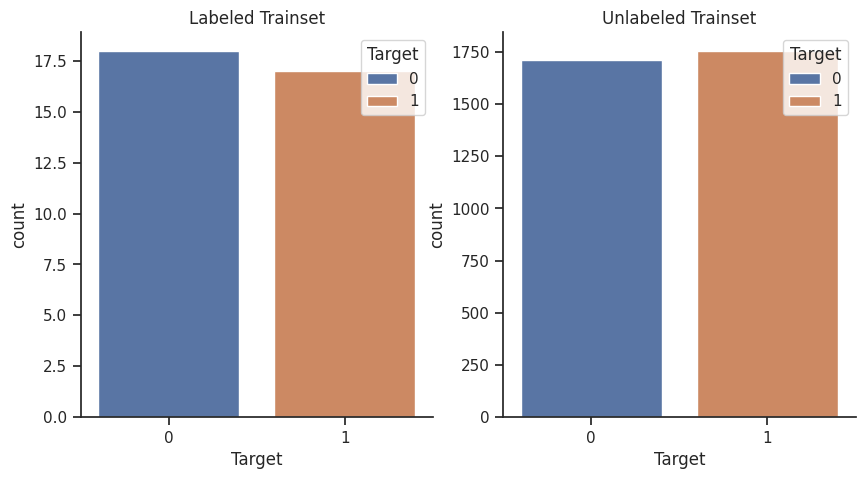

In [ ]:
# Visualize distribution of target variable
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x="Target", hue="Target", data=y_train_lab_df, ax=axs[0])
axs[0].set_title("Labeled Trainset")
sns.countplot(x="Target", hue="Target", data=y_train_unlab_df, ax=axs[1])
axs[1].set_title("Unlabeled Trainset")
plt.show()


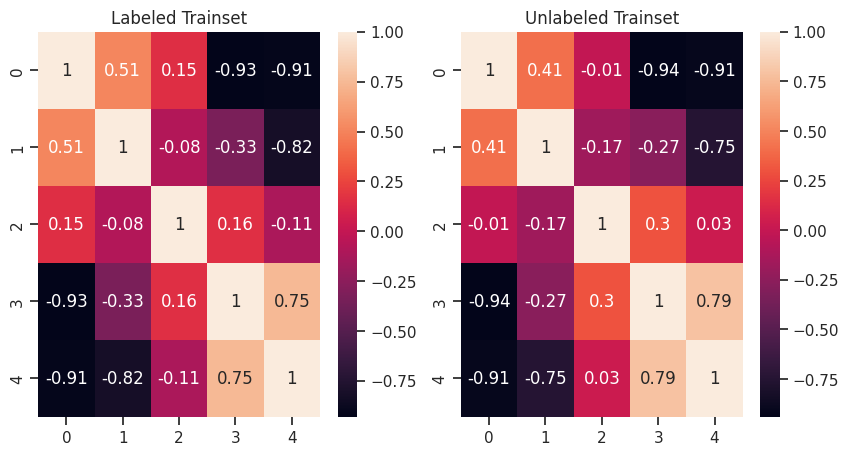

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(X_train_lab_df.corr(), 2), annot=True, ax=axs[0])
axs[0].set_title("Labeled Trainset")
sns.heatmap(np.round(X_train_unlab_df.corr(), 2), annot=True, ax=axs[1])
axs[1].set_title("Unlabeled Trainset")
plt.show()

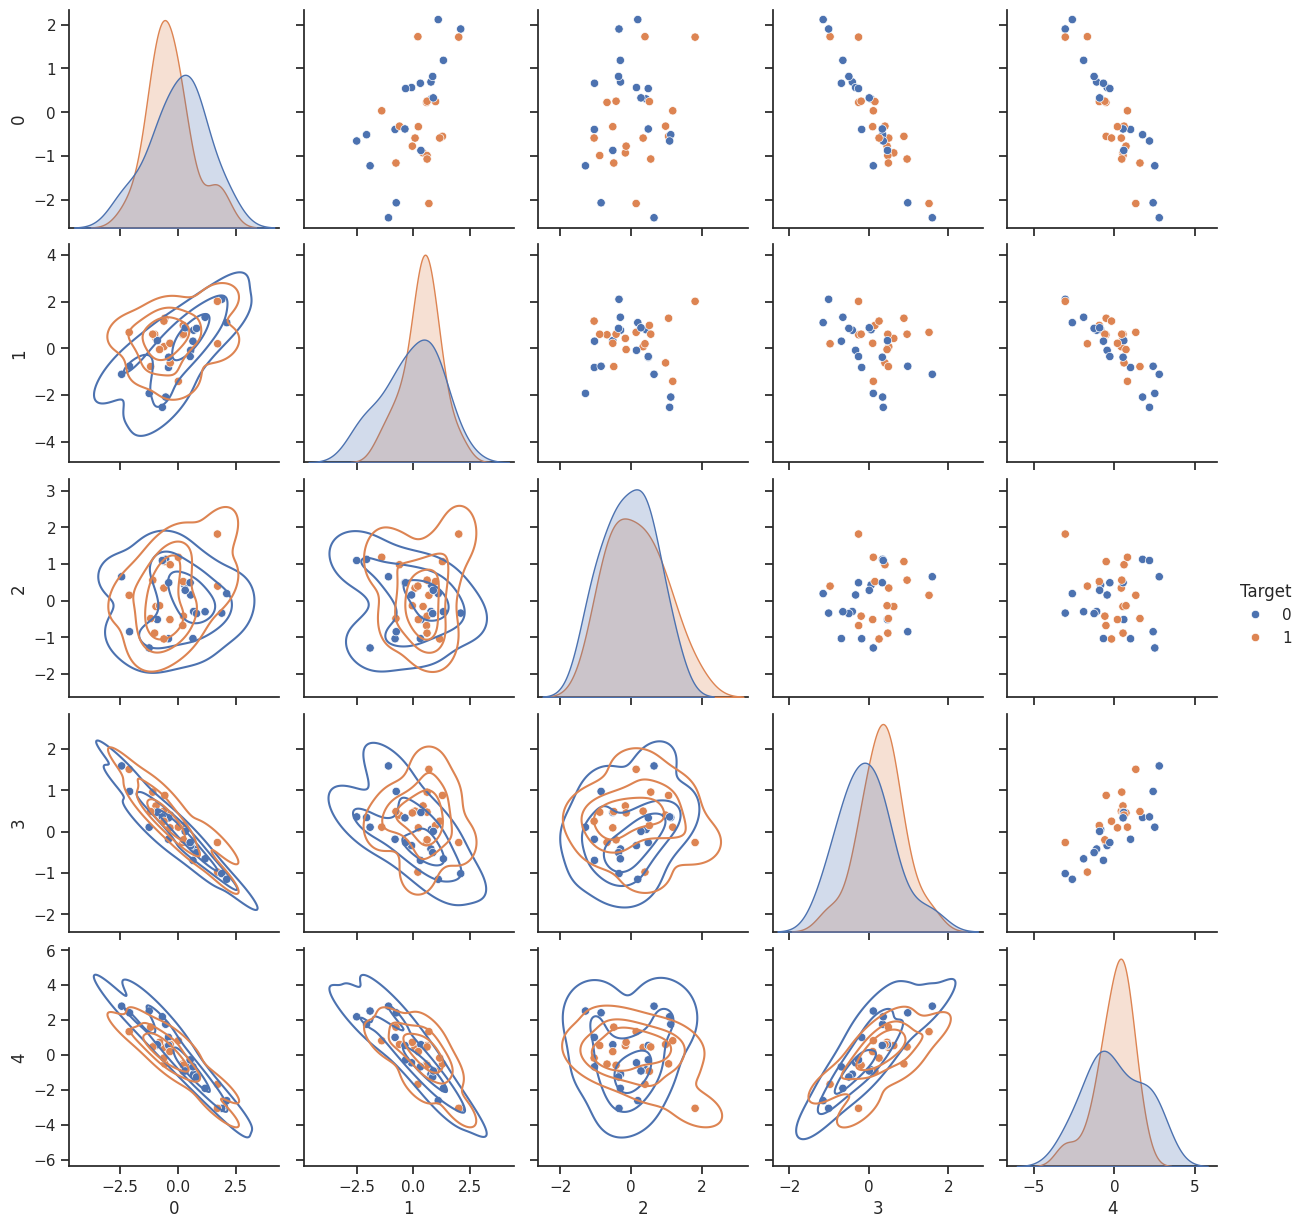

In [ ]:

train_lab_df = pd.concat([X_train_lab_df, y_train_lab_df], axis=1)
sns.pairplot(train_lab_df, hue='Target', diag_kind='kde').map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

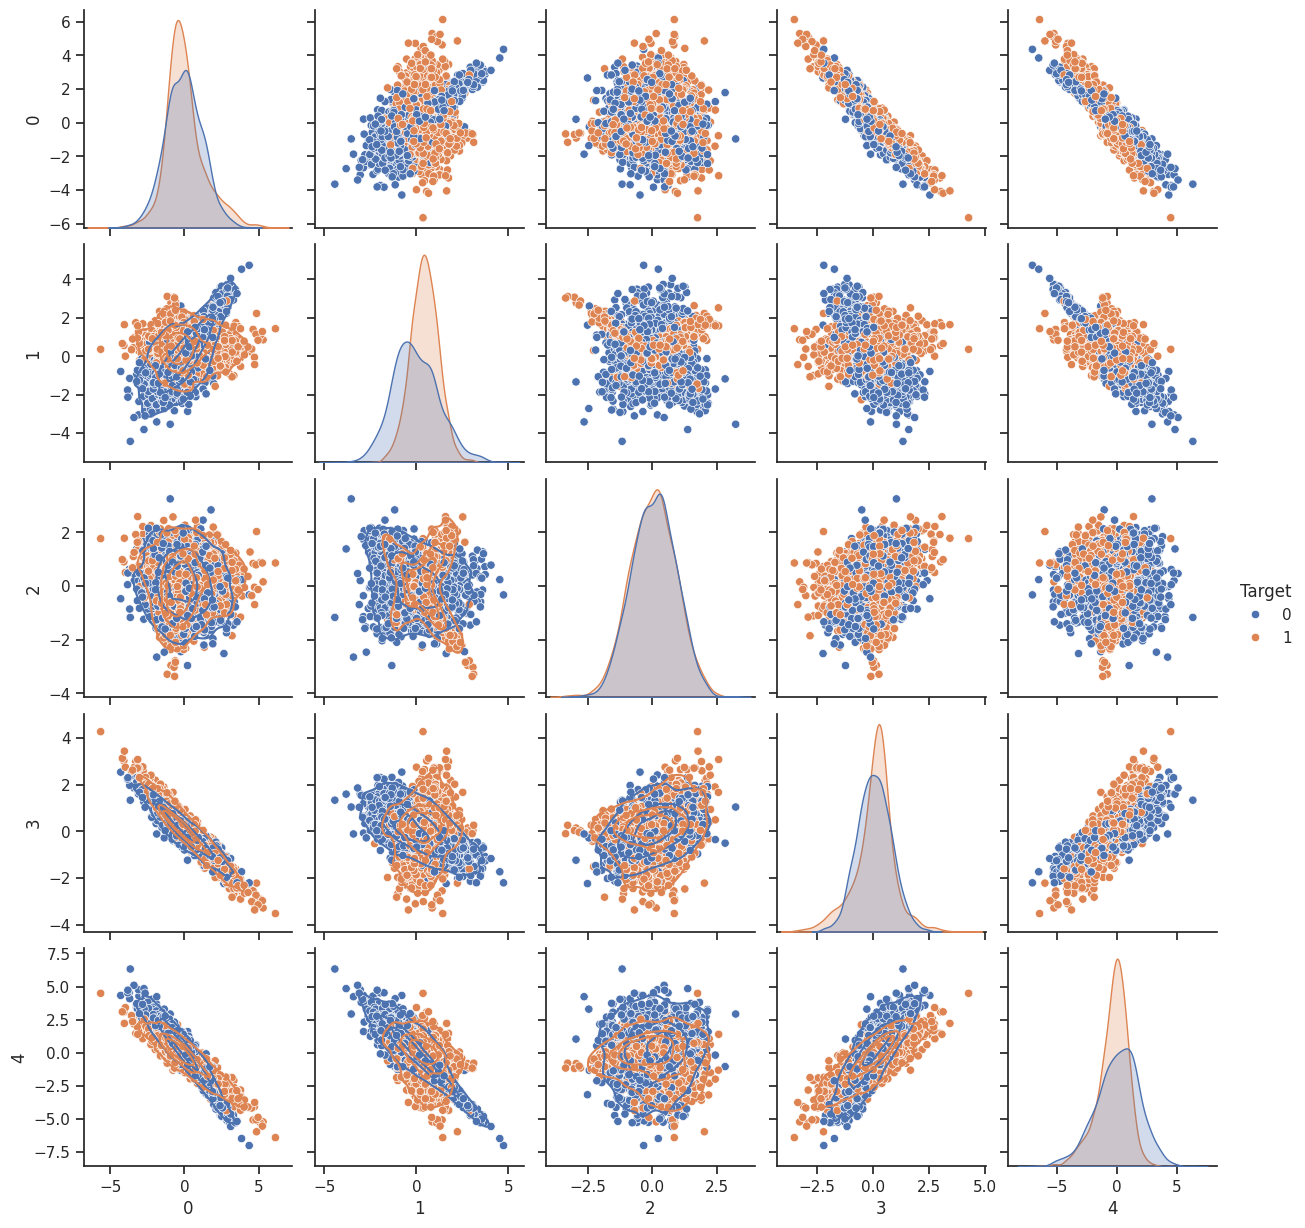

In [ ]:
train_unlab_df = pd.concat([X_train_unlab_df, y_train_unlab_df], axis=1)
sns.pairplot(train_unlab_df, hue='Target', diag_kind='kde').map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

# 3. 단순 SVM 학습 및 평가
향후 실험은 labled data와 unlabeled data를 모두 활용한 Self Train을 적용하여 진행할 예정입니다.\
모든 실험의 성능을 비교하기 위해 단순 SVM을 학습하고 평가합니다.

In [ ]:
def calc_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)

    return {
        "F1 Score"  : round(f1,4),
        "Recall"    : round(recall,4),
        "Precision" : round(precision,4),
        "Accuracy"  : round(accuracy,4),
        "AUROC"     : round(auc_roc,4)
    }

def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
result_dict = defaultdict(dict)

# 4. SVM을 통한 pseudo labeling 및 분석
labeled 데이터로 학습된 SVM 모델을 이용하여 pseudo labeling을 진행하겠습니다.\
pseudo labeling을 통해 unlabeled 데이터를 라벨링하고, 이를 이용하여 모델을 학습합니다.\
실제 pseudo labeling 작업을 수행하고 이를 관찰해보도록 하겠습니다.

In [ ]:
def get_pred(model, X):
    probability = model.predict_proba(X)
    prediction = probability.argmax(axis=1)
    pred_and_conf = []
    for pred, prob in zip(prediction, probability):
        pred_and_conf.append([pred, prob[pred]])
    return np.array(pred_and_conf)

In [ ]:
# model = RandomForestClassifier()
model = SVC(probability=True, random_state=42)
model.fit(np.concatenate([X_lab_train, X_unlab_train]), np.concatenate([y_lab_train, y_unlab_train]))

SVC(probability=True, random_state=42)

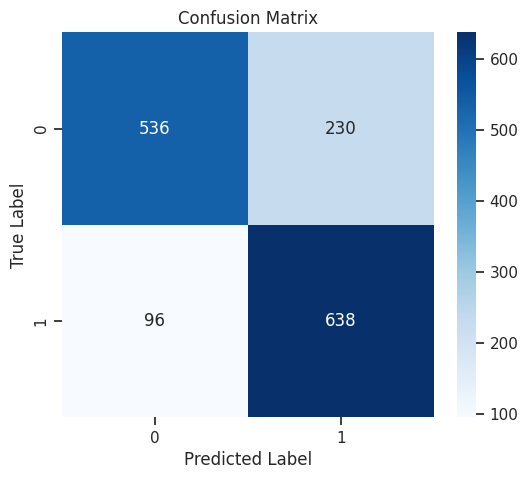

Full Trained SVC: 
F1 Score  : 0.7965
Recall    : 0.8692
Precision : 0.7350
Accuracy  : 0.7827
AUROC     : 0.7845


In [ ]:
# Evaluate the trained SVC model on the test set
y_pred = model.predict(X_test)

# Visualize the confusion matrix
show_confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calculate and print various evaluation metrics
print('Full Trained SVC: ')
svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
result_dict['Full Trained SVC'] = svm_metrics
for k, v in svm_metrics.items():
    print(f'{k:10s}: {v:.4f}')

In [ ]:
# model = RandomForestClassifier()
model = SVC(probability=True, random_state=42)
model.fit(X_lab_train, y_lab_train)

SVC(probability=True, random_state=42)

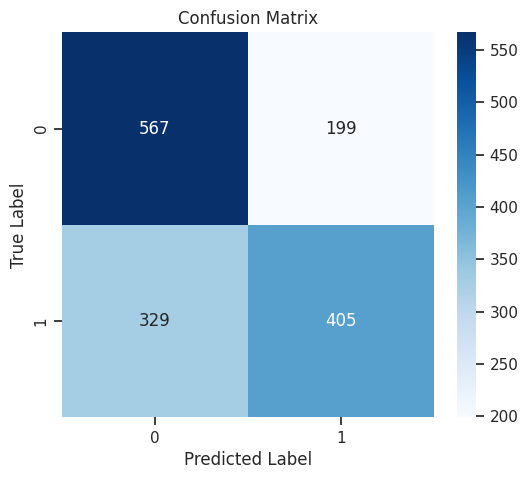

Default SVC: 
F1 Score  : 0.6054
Recall    : 0.5518
Precision : 0.6705
Accuracy  : 0.6480
AUROC     : 0.6460


In [ ]:
# Evaluate the trained SVC model on the test set
y_pred = model.predict(X_test)
# Visualize the confusion matrix
show_confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calculate and print various evaluation metrics
print('Default SVC: ')
svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
result_dict['Default SVC'] = svm_metrics
for k, v in svm_metrics.items():
    print(f'{k:10s}: {v:.4f}')

In [ ]:
pred_and_conf = get_pred(model, X_unlab_train)

## confidence 시각화 및 confidence 별 정확도 확인

In [ ]:
hit = [(pred == y, conf) for [pred, conf], y in zip(pred_and_conf, y_unlab_train)]
acc_per_conf_invertal = defaultdict(list)
for h, conf in hit:
    interval = int(conf*100)//5*5
    acc_per_conf_invertal[interval].append(h)

acc_per_conf_invertal = {k: np.mean(v) for k, v in acc_per_conf_invertal.items()}

Text(0, 0.5, 'Count')

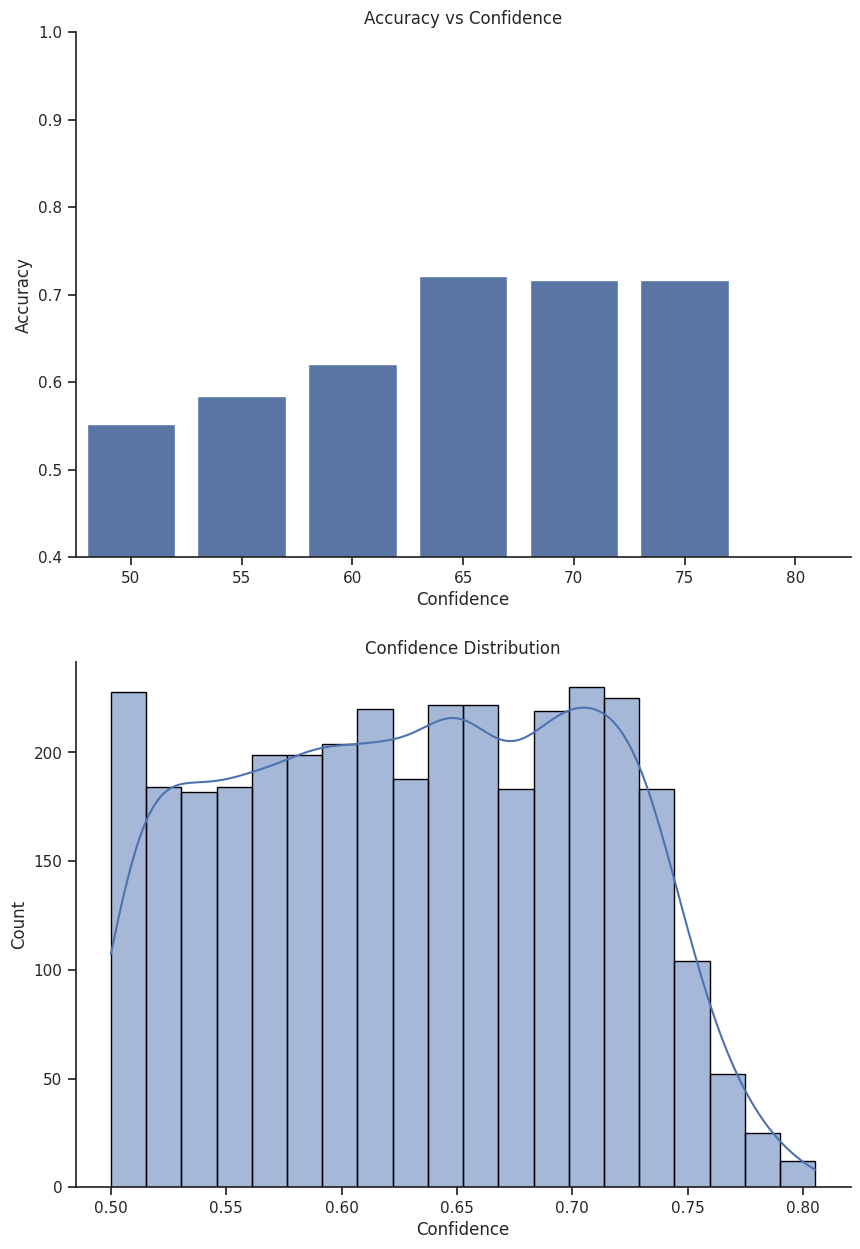

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.barplot(x=acc_per_conf_invertal.keys(), y=acc_per_conf_invertal.values(), ax=axs[0])
axs[0].set_ylim(0.4, 1)
axs[0].set_title("Accuracy vs Confidence")
axs[0].set_xlabel("Confidence")
axs[0].set_ylabel("Accuracy")

sns.histplot([conf for _, conf in hit], bins=20, edgecolor='black',kde=True, ax=axs[1])
axs[1].set_title("Confidence Distribution")
axs[1].set_xlabel("Confidence")
axs[1].set_ylabel("Count")

# 5. Self Training 구현
Pseudo labeling을 통해 얻은 데이터를 이용하여 Self Training을 구현하겠습니다.\
Self Training을 통해 모델을 학습하고, 이를 평가합니다.
## 5-1. Self Training 과정
Self Training은 학습 - pseudo labeling - 학습 의 과정을 반복합니다.\
본 실습에서도 위 과정을 반복적으로 실행하면서 test 데이터에 대한 성능 변화를 살펴보도록 하겠습니다.

In [ ]:
# pseudo labeling을 수행하는 함수
# thrshold를 넘지 못하는 데이터는 unlabeld 데이터로 반환합니다.
def get_pseudo_label(model, X_unlab, y_unlab, threshold=0.75):
    pred_and_conf = get_pred(model, X_unlab)
    pseudo_label = []
    for pred, conf in pred_and_conf:
        if conf > threshold:
            pseudo_label.append(pred)
        else:
            pseudo_label.append(-1)
    new_train_lab_x = []
    new_train_lab_y = []
    new_train_pseudo_y = []
    new_train_unlab_x = []
    new_train_unlab_y = []
    for x, y, pseudo_y in zip(X_unlab, y_unlab, pseudo_label):
        if pseudo_y != -1:
            new_train_lab_x.append(x)
            new_train_lab_y.append(y)
            new_train_pseudo_y.append(pseudo_y)
        else:
            new_train_unlab_x.append(x)
            new_train_unlab_y.append(y)
    return  {
        'pseudo_labeled': (np.array(new_train_lab_x), np.array(new_train_lab_y), np.array(new_train_pseudo_y)),
        'unlabeled': (np.array(new_train_unlab_x), np.array(new_train_unlab_y))
    }

In [ ]:
# pseudo labeling을 통해 확보한 추가 labeled 데이터 병합 함수
def merge_data(original_labeld_x, original_labeld_y, pseudo_labeled_x, pseudo_labeled_y):
    if len(pseudo_labeled_x) == 0:
        raise ValueError('No pseudo labeled data: Lower the threshold or check the model.')
    return np.concatenate([original_labeld_x, pseudo_labeled_x]), np.concatenate([original_labeld_y, pseudo_labeled_y])

In [ ]:
# self training 1회 과정
# 모델 학습 -> pseudo labeling -> pseudo labeling 데이터와 기존 labeled 데이터 병합
def self_train_iter(model, labeled_train_x, labeled_train_y, unlabeled_train_x, unlabeled_train_y, threshold=0.75):
    model.fit(labeled_train_x, labeled_train_y)
    unlab_data = get_pseudo_label(model, unlabeled_train_x, unlabeled_train_y, threshold)
    pseudo_labeled = unlab_data['pseudo_labeled']
    unlabeled = unlab_data['unlabeled']
    new_labeled_x, new_labeled_y = merge_data(labeled_train_x, labeled_train_y, pseudo_labeled[0], pseudo_labeled[2])
    original_y = pseudo_labeled[1]
    return model, new_labeled_x, new_labeled_y, original_y, unlabeled[0], unlabeled[1]


In [ ]:
# model = RandomForestClassifier()
model = SVC(probability=True, random_state=42)
model, new_labeled_x, new_labeled_y, original_y, new_unlabeled_x, new_unlabeled_y = self_train_iter(model, X_lab_train, y_lab_train, X_unlab_train, y_unlab_train,threshold=0.75)

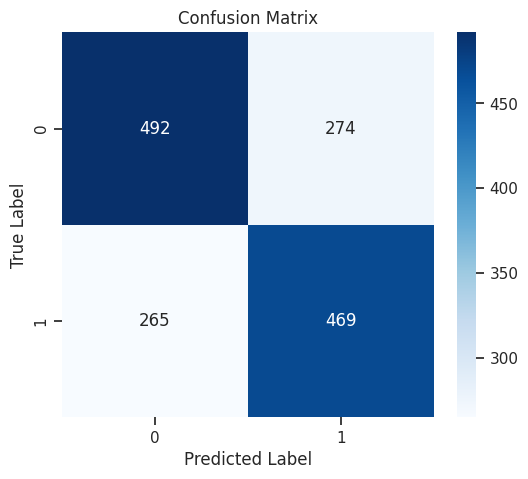

Self Train(iter: 1): 
F1 Score  : 0.6351
Recall    : 0.6390
Precision : 0.6312
Accuracy  : 0.6407
AUROC     : 0.6406


In [ ]:
model = RandomForestClassifier()
model.fit(new_labeled_x, new_labeled_y)
# Evaluate the trained SVC model on the test set
y_pred = model.predict(X_test)

# Visualize the confusion matrix
show_confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calculate and print various evaluation metrics
print('Self Train(iter: 1): ')
svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
result_dict['Self Train(iter: 1)'] = svm_metrics
for k, v in svm_metrics.items():
    print(f'{k:10s}: {v:.4f}')

In [ ]:
pd.DataFrame(result_dict).T

,F1 Score,Recall,Precision,Accuracy,AUROC
Full Trained SVC,0.7965,0.8692,0.7350,0.7827,0.7845
Default SVC,0.6054,0.5518,0.6705,0.6480,0.6460
Self Train(iter: 1),0.6351,0.6390,0.6312,0.6407,0.6406


# 6. Self Training 및 단순 SVM 성능 비교
총 10회의 self train을 반복하여 각 iteration 별 test 성능을 비교해보겠습니다.


Self Train(iter: 1)
# of labeled data: 35
# of unlabeled data: 3465
          


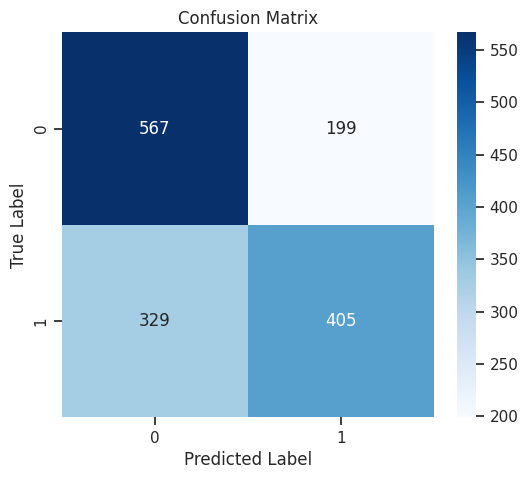

Self Train(iter: 2): 
# of labeled data: 38.0000
# of unlabeled data: 3462.0000
F1 Score  : 0.6054
Recall    : 0.5518
Precision : 0.6705
Accuracy  : 0.6480
AUROC     : 0.6460

Self Train(iter: 2)
# of labeled data: 38
# of unlabeled data: 3462
          


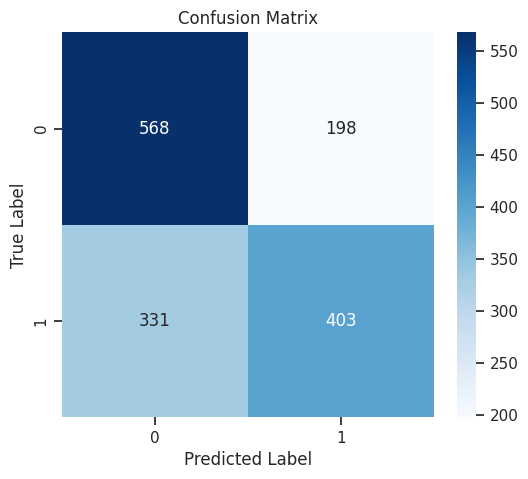

Self Train(iter: 3): 
# of labeled data: 373.0000
# of unlabeled data: 3127.0000
F1 Score  : 0.6037
Recall    : 0.5490
Precision : 0.6705
Accuracy  : 0.6473
AUROC     : 0.6453

Self Train(iter: 3)
# of labeled data: 373
# of unlabeled data: 3127
          


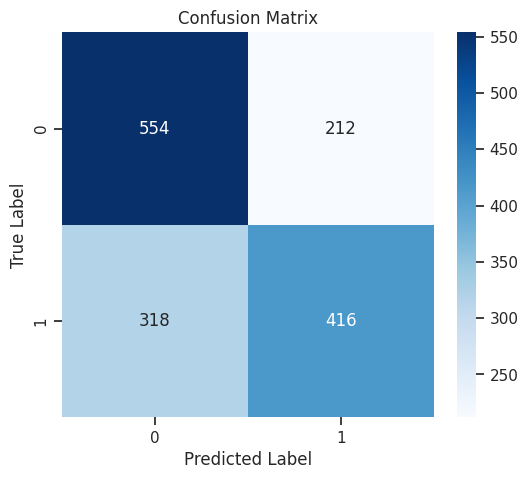

Self Train(iter: 4): 
# of labeled data: 2054.0000
# of unlabeled data: 1446.0000
F1 Score  : 0.6109
Recall    : 0.5668
Precision : 0.6624
Accuracy  : 0.6467
AUROC     : 0.6450

Self Train(iter: 4)
# of labeled data: 2054
# of unlabeled data: 1446
          


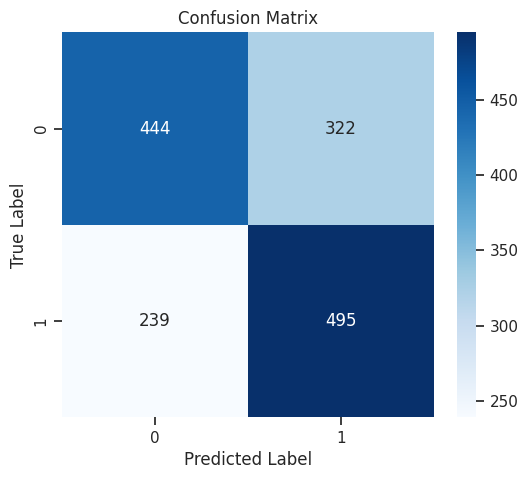

Self Train(iter: 5): 
# of labeled data: 3009.0000
# of unlabeled data: 491.0000
F1 Score  : 0.6383
Recall    : 0.6744
Precision : 0.6059
Accuracy  : 0.6260
AUROC     : 0.6270

Self Train(iter: 5)
# of labeled data: 3009
# of unlabeled data: 491
          


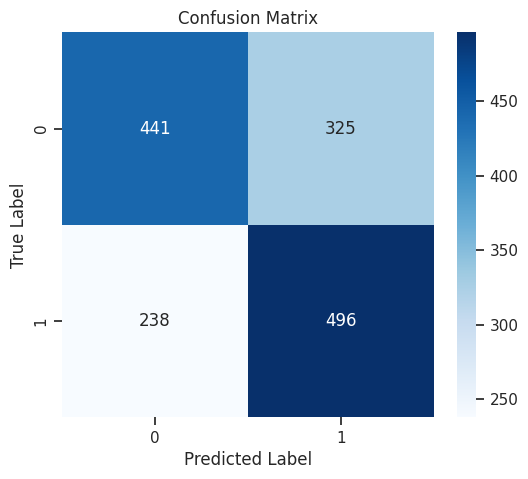

Self Train(iter: 6): 
# of labeled data: 3238.0000
# of unlabeled data: 262.0000
F1 Score  : 0.6379
Recall    : 0.6757
Precision : 0.6041
Accuracy  : 0.6247
AUROC     : 0.6257

Self Train(iter: 6)
# of labeled data: 3238
# of unlabeled data: 262
          


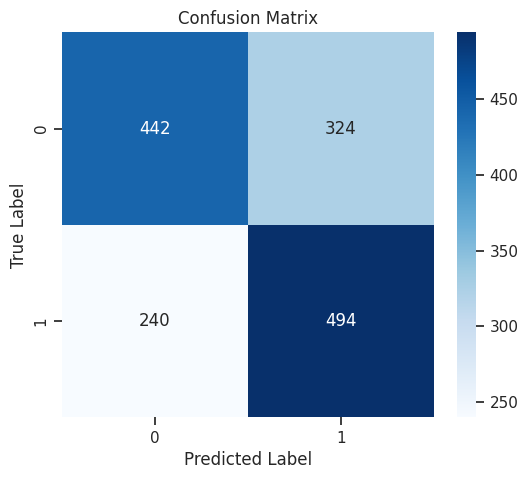

Self Train(iter: 7): 
# of labeled data: 3304.0000
# of unlabeled data: 196.0000
F1 Score  : 0.6366
Recall    : 0.6730
Precision : 0.6039
Accuracy  : 0.6240
AUROC     : 0.6250

Self Train(iter: 7)
# of labeled data: 3304
# of unlabeled data: 196
          


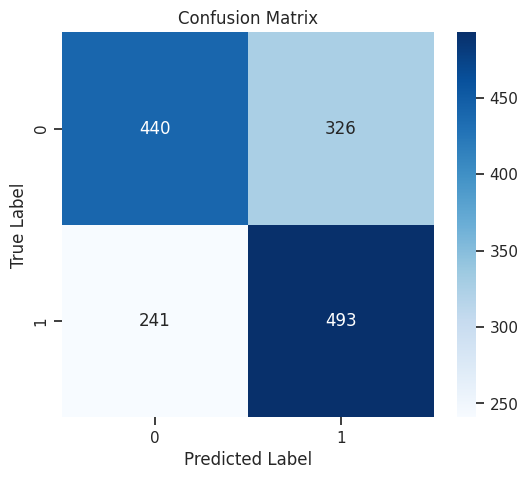

Self Train(iter: 8): 
# of labeled data: 3323.0000
# of unlabeled data: 177.0000
F1 Score  : 0.6349
Recall    : 0.6717
Precision : 0.6020
Accuracy  : 0.6220
AUROC     : 0.6230

Self Train(iter: 8)
# of labeled data: 3323
# of unlabeled data: 177
          


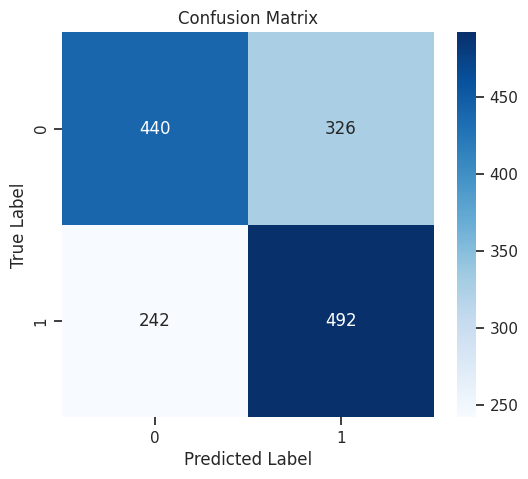

Self Train(iter: 9): 
# of labeled data: 3335.0000
# of unlabeled data: 165.0000
F1 Score  : 0.6340
Recall    : 0.6703
Precision : 0.6015
Accuracy  : 0.6213
AUROC     : 0.6224

Self Train(iter: 9)
# of labeled data: 3335
# of unlabeled data: 165
          


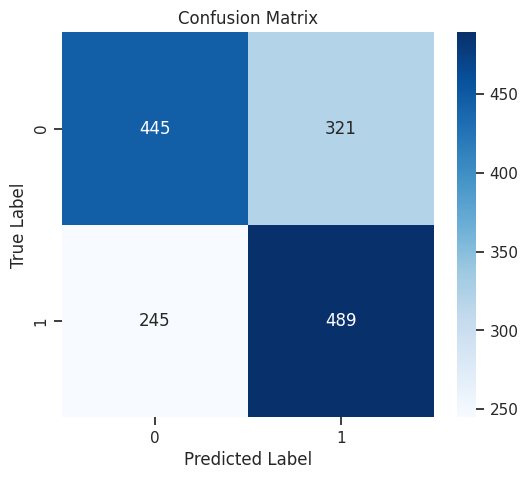

Self Train(iter: 10): 
# of labeled data: 3341.0000
# of unlabeled data: 159.0000
F1 Score  : 0.6334
Recall    : 0.6662
Precision : 0.6037
Accuracy  : 0.6227
AUROC     : 0.6236

Self Train(iter: 10)
# of labeled data: 3341
# of unlabeled data: 159
          


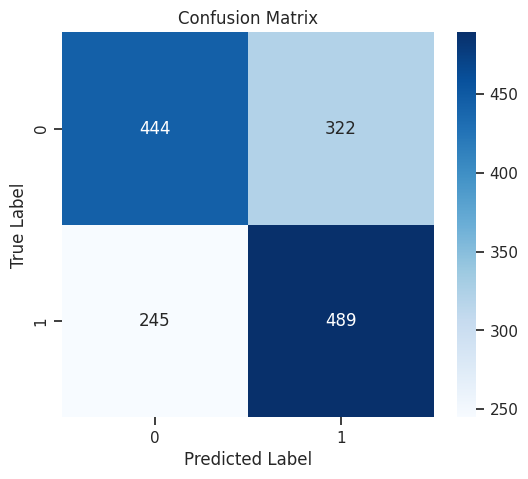

Self Train(iter: 11): 
# of labeled data: 3349.0000
# of unlabeled data: 151.0000
F1 Score  : 0.6330
Recall    : 0.6662
Precision : 0.6030
Accuracy  : 0.6220
AUROC     : 0.6229


In [ ]:
new_labeled_x = X_lab_train.copy()
new_labeled_y = y_lab_train.copy()
new_unlabeled_x = X_unlab_train.copy()
new_unlabeled_y = y_unlab_train.copy()

len_labeled = []
len_unlabeled = []

for iter in range(10):
    print(f"""
==========================================================================================
Self Train(iter: {iter+1})
==============================
# of labeled data: {len(new_labeled_x)}
# of unlabeled data: {len(new_unlabeled_x)}
          """)
    len_labeled.append(len(new_labeled_x))
    len_unlabeled.append(len(new_unlabeled_x))
    model = copy.deepcopy(SVC(probability=True, random_state=42))
    model, new_labeled_x, new_labeled_y, original_y, new_unlabeled_x, new_unlabeled_y = self_train_iter(model, new_labeled_x, new_labeled_y, new_unlabeled_x, new_unlabeled_y, threshold=0.8)

    # Evaluate the trained SVC model on the test set
    y_pred = model.predict(X_test)

    # Visualize the confusion matrix
    show_confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Calculate and print various evaluation metrics
    print(f'Self Train(iter: {iter+2}): ')
    svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
    svm_metrics = {'# of labeled data': len(new_labeled_x), '# of unlabeled data': len(new_unlabeled_x), **svm_metrics}
    result_dict[f'Self Train(iter: {iter+1})'] = svm_metrics
    for k, v in svm_metrics.items():
        print(f'{k:10s}: {v:.4f}')

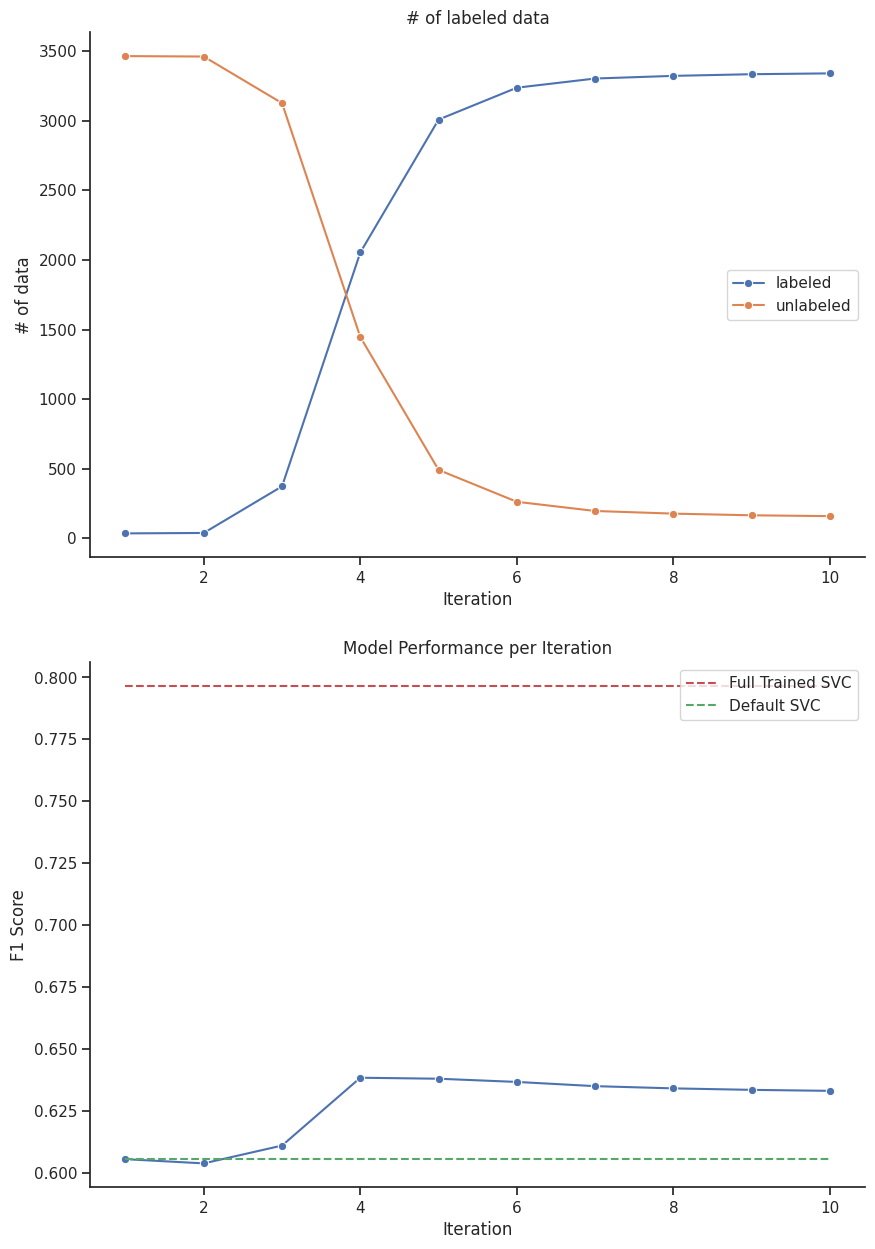

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.lineplot(x=range(1, 11), y=len_labeled, ax=axs[0], legend=True, label='labeled', marker='o')
sns.lineplot(x=range(1, 11), y=len_unlabeled, ax=axs[0], legend=True, label='unlabeled', marker='o')
axs[0].set_title("# of labeled data")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("# of data")

sns.lineplot(x=range(1, 11), y=pd.DataFrame(result_dict).T.iloc[2:]['F1 Score'], ax=axs[1], marker='o')
axs[1].set_title("Model Performance per Iteration")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("F1 Score")
axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[0]['F1 Score'], xmin=1, xmax=10, colors='r', linestyles='dashed', label='Full Trained SVC')
axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[1]['F1 Score'], xmin=1, xmax=10, colors='g', linestyles='dashed', label='Default SVC')
axs[1].legend()
plt.show()

# 7. Self Training 상황 별 분석
Self Train은 항상 좋은 성능을 보장할 수 있는 방법론은 아닙니다.\
몇가지 상황을 비교하며 Self Train의 한계점을 살펴보겠습니다.

## 7-1. 초기 Labeled Dataset 수에 따른 성능 변화

In [ ]:
comparison_lab_dict = {}
comparison_lab_dict['full'] = result_dict['Full Trained SVC']
comparison_lab_dict['lab_35'] = result_dict['Default SVC']
comparison_lab_dict['lab_35_best_st'] = result_dict['Self Train(iter: 4)']

In [ ]:
X_lab_train, X_unlab_train, y_lab_train, y_unlab_train = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

print('Trainset: ',X_train.shape)
print('Labelled Trainset: ',X_lab_train.shape)
print('Unlabelled Trainset: ',X_unlab_train.shape)
print('Testset: ',X_test.shape)

Trainset:  (3500, 5)
Labelled Trainset:  (350, 5)
Unlabelled Trainset:  (3150, 5)
Testset:  (1500, 5)


In [ ]:
result_dict = defaultdict(dict)

In [ ]:
# model = RandomForestClassifier()
model = SVC(probability=True, random_state=42)
model.fit(X_lab_train, y_lab_train)

SVC(probability=True, random_state=42)

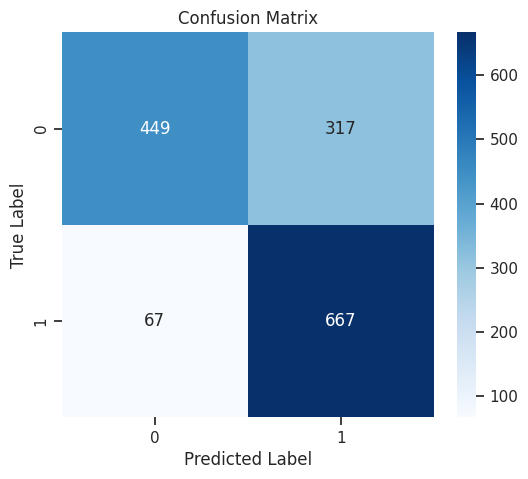

Default SVC: 
F1 Score  : 0.7765
Recall    : 0.9087
Precision : 0.6778
Accuracy  : 0.7440
AUROC     : 0.7474


In [ ]:
# Evaluate the trained SVC model on the test set
y_pred = model.predict(X_test)
# Visualize the confusion matrix
show_confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calculate and print various evaluation metrics
print('Default SVC: ')
svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
result_dict['Default SVC'] = svm_metrics
for k, v in svm_metrics.items():
    print(f'{k:10s}: {v:.4f}')

In [ ]:
new_labeled_x = X_lab_train.copy()
new_labeled_y = y_lab_train.copy()
new_unlabeled_x = X_unlab_train.copy()
new_unlabeled_y = y_unlab_train.copy()

len_labeled = []
len_unlabeled = []

for iter in range(10):
    len_labeled.append(len(new_labeled_x))
    len_unlabeled.append(len(new_unlabeled_x))
    model = copy.deepcopy(SVC(probability=True, random_state=42))
    model, new_labeled_x, new_labeled_y, original_y, new_unlabeled_x, new_unlabeled_y = self_train_iter(model, new_labeled_x, new_labeled_y, new_unlabeled_x, new_unlabeled_y, threshold=0.8)

    # Evaluate the trained SVC model on the test set
    y_pred = model.predict(X_test)

    # Calculate and print various evaluation metrics
    print(f'Self Train(iter: {iter+1})')
    svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
    svm_metrics = {'# of labeled data': len(new_labeled_x), '# of unlabeled data': len(new_unlabeled_x), **svm_metrics}
    result_dict[f'Self Train(iter: {iter+1})'] = svm_metrics

Self Train(iter: 1)
Self Train(iter: 2)
Self Train(iter: 3)
Self Train(iter: 4)
Self Train(iter: 5)
Self Train(iter: 6)
Self Train(iter: 7)
Self Train(iter: 8)
Self Train(iter: 9)
Self Train(iter: 10)


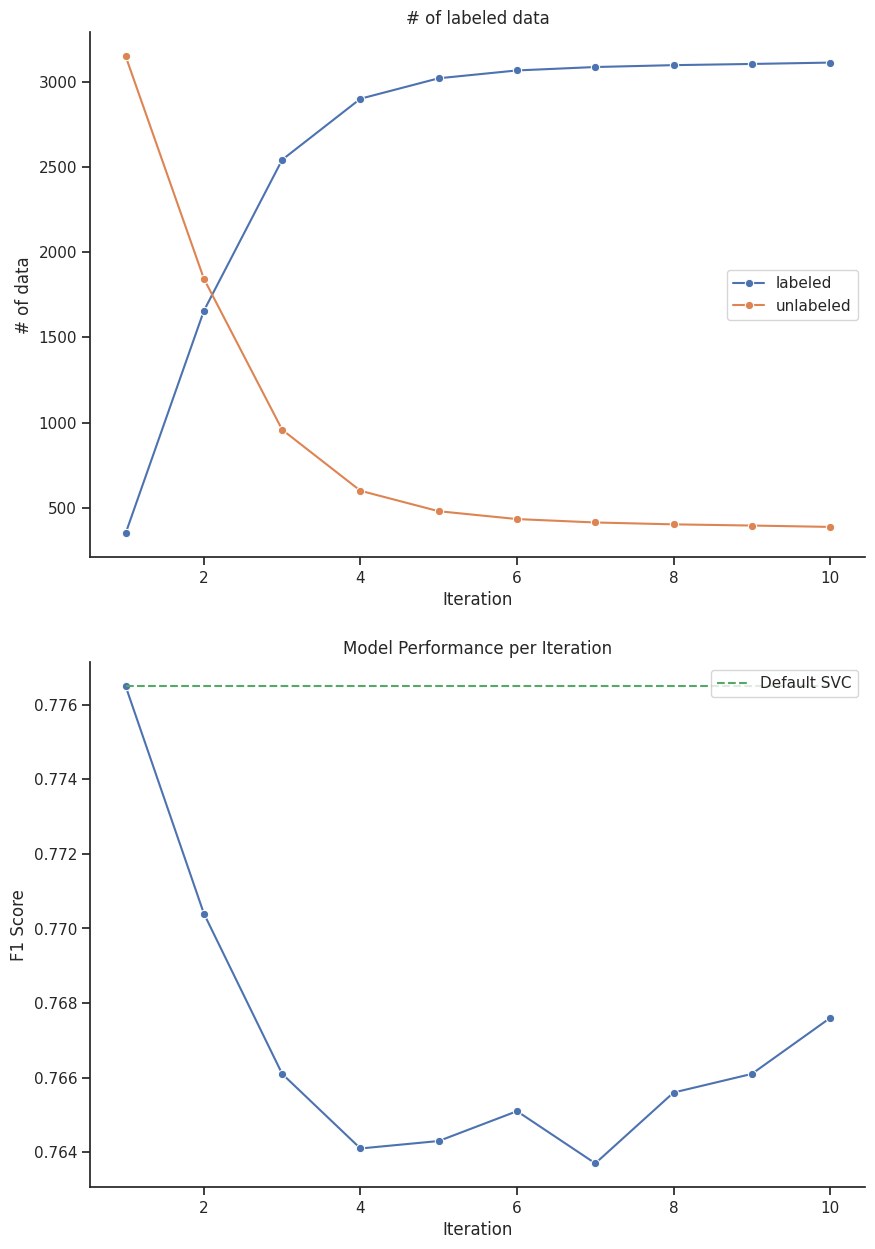

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.lineplot(x=range(1, 11), y=len_labeled, ax=axs[0], legend=True, label='labeled', marker='o')
sns.lineplot(x=range(1, 11), y=len_unlabeled, ax=axs[0], legend=True, label='unlabeled', marker='o')
axs[0].set_title("# of labeled data")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("# of data")

sns.lineplot(x=range(1, 11), y=pd.DataFrame(result_dict).T.iloc[1:]['F1 Score'], ax=axs[1], marker='o')
axs[1].set_title("Model Performance per Iteration")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("F1 Score")
# axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[0]['F1 Score'], xmin=1, xmax=10, colors='r', linestyles='dashed', label='Full Trained SVC')
axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[1]['F1 Score'], xmin=1, xmax=10, colors='g', linestyles='dashed', label='Default SVC')
axs[1].legend()
plt.show()

In [ ]:
comparison_lab_dict['lab_350_best_st'] = result_dict['Self Train(iter: 2)']
comparison_lab_dict['lab_350'] = result_dict['Default SVC']

In [ ]:
pd.DataFrame(comparison_lab_dict).T

,F1 Score,Recall,Precision,Accuracy,AUROC,# of labeled data,# of unlabeled data
full,0.7965,0.8692,0.7350,0.7827,0.7845,NaN,NaN
lab_35,0.6054,0.5518,0.6705,0.6480,0.6460,NaN,NaN
lab_35_best_st,0.6383,0.6744,0.6059,0.6260,0.6270,3009.0,491.0
lab_350_best_st,0.7704,0.8665,0.6936,0.7473,0.7498,2542.0,958.0
lab_350,0.7765,0.9087,0.6778,0.7440,0.7474,NaN,NaN


# 7-2. Threshold에 따른 성능 변화

이렇게 Self Train 적용 시 성능이 저하되는 이유는 Pseudo Labeling에 있습니다.\
Pseudo Labeling은 모델이 잘못 예측한 데이터에 대해 잘못된 라벨을 부여하게 됩니다.\
이러한 잘못된 라벨이 모델 학습에 영향을 미치게 되어 성능이 저하될 수 있습니다.

In [ ]:
# model = RandomForestClassifier()
model = SVC(probability=True, random_state=42)
model.fit(X_lab_train, y_lab_train)

SVC(probability=True, random_state=42)

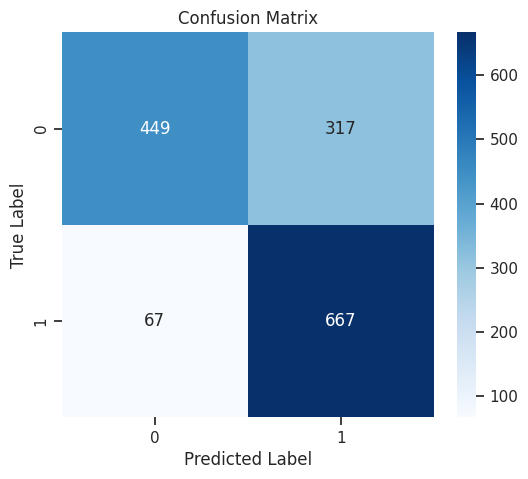

Default SVC: 


In [ ]:
# Evaluate the trained SVC model on the test set
y_pred = model.predict(X_test)
# Visualize the confusion matrix
show_confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calculate and print various evaluation metrics
print('Default SVC: ')
svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)

pred_and_conf = get_pred(model, X_unlab_train)
hit = [(pred == y, conf) for [pred, conf], y in zip(pred_and_conf, y_unlab_train)]
acc_per_conf_invertal = defaultdict(list)
for h, conf in hit:
    interval = int(conf*100)//5*5
    acc_per_conf_invertal[interval].append(h)

acc_per_conf_invertal = {k: np.mean(v) for k, v in acc_per_conf_invertal.items()}

Text(0, 0.5, 'Count')

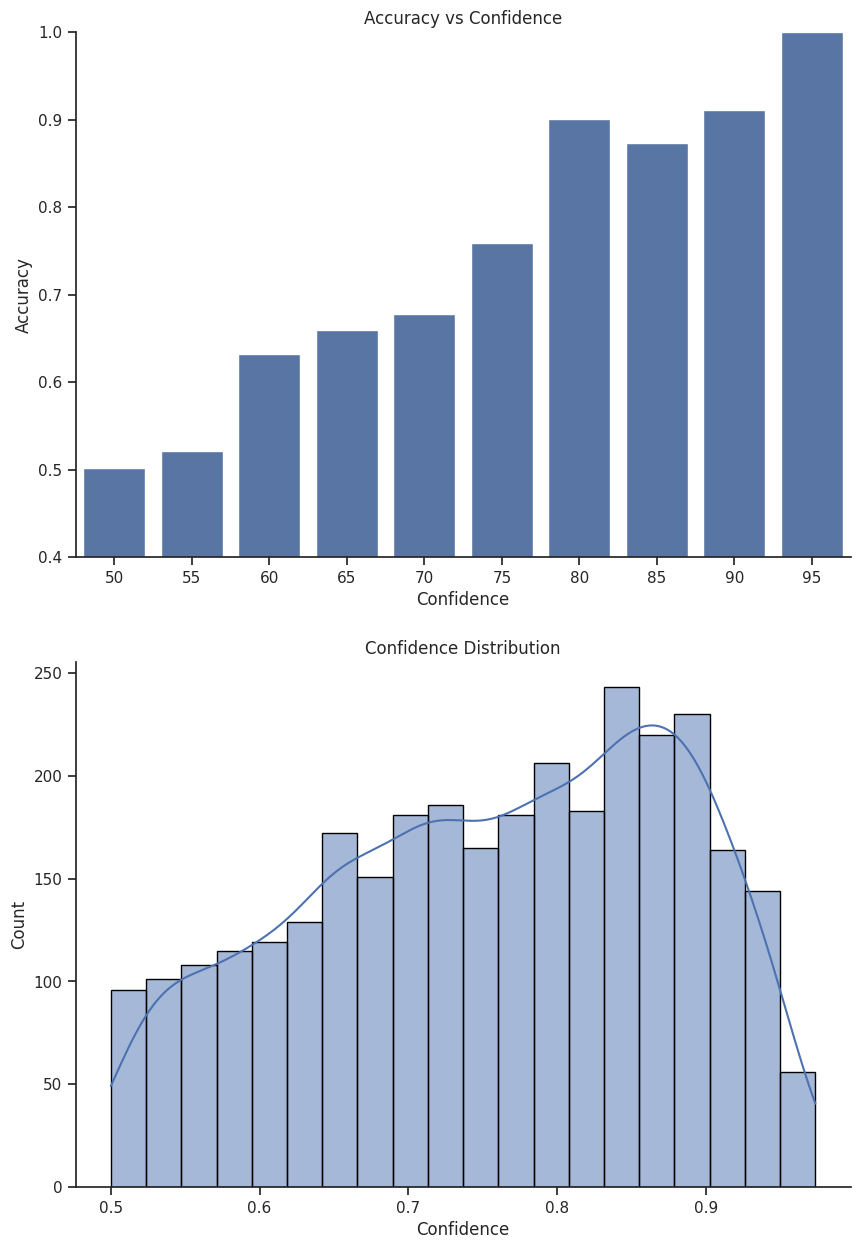

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.barplot(x=acc_per_conf_invertal.keys(), y=acc_per_conf_invertal.values(), ax=axs[0])
axs[0].set_ylim(0.4, 1)
axs[0].set_title("Accuracy vs Confidence")
axs[0].set_xlabel("Confidence")
axs[0].set_ylabel("Accuracy")

sns.histplot([conf for _, conf in hit], bins=20, edgecolor='black',kde=True, ax=axs[1])
axs[1].set_title("Confidence Distribution")
axs[1].set_xlabel("Confidence")
axs[1].set_ylabel("Count")

labeled 데이터로만 학습된 모델의 confidence를 분석해보면, labeled 데이터가 35개였을 때보다 높은 confidence를 보이는 데이터가 증가한 것을 볼 수 있습니다.\
하지만 Self Train 시 Threshold를 변경하지 않아, 모델의 예측이 정확하지 않은 데이터에 대해서도 pseudo labeling이 진행되어 성능이 저하되었을 수 있습니다.

In [ ]:
result_dict_for_threshold = defaultdict(dict)
new_labeled_x = X_lab_train.copy()
new_labeled_y = y_lab_train.copy()
new_unlabeled_x = X_unlab_train.copy()
new_unlabeled_y = y_unlab_train.copy()

len_labeled = []
len_unlabeled = []

for iter in range(10):
    len_labeled.append(len(new_labeled_x))
    len_unlabeled.append(len(new_unlabeled_x))
    model = copy.deepcopy(SVC(probability=True, random_state=42))
    model, new_labeled_x, new_labeled_y, original_y, new_unlabeled_x, new_unlabeled_y = self_train_iter(model, new_labeled_x, new_labeled_y, new_unlabeled_x, new_unlabeled_y, threshold=0.95)

    # Evaluate the trained SVC model on the test set
    y_pred = model.predict(X_test)

    # Calculate and print various evaluation metrics
    print(f'Self Train(iter: {iter+1})')
    svm_metrics = calc_metrics(y_true=y_test, y_pred=y_pred)
    svm_metrics = {'# of labeled data': len(new_labeled_x), '# of unlabeled data': len(new_unlabeled_x), **svm_metrics}
    result_dict_for_threshold[f'Self Train(iter: {iter+1})'] = svm_metrics

Self Train(iter: 1)
Self Train(iter: 2)
Self Train(iter: 3)
Self Train(iter: 4)
Self Train(iter: 5)
Self Train(iter: 6)
Self Train(iter: 7)
Self Train(iter: 8)
Self Train(iter: 9)
Self Train(iter: 10)


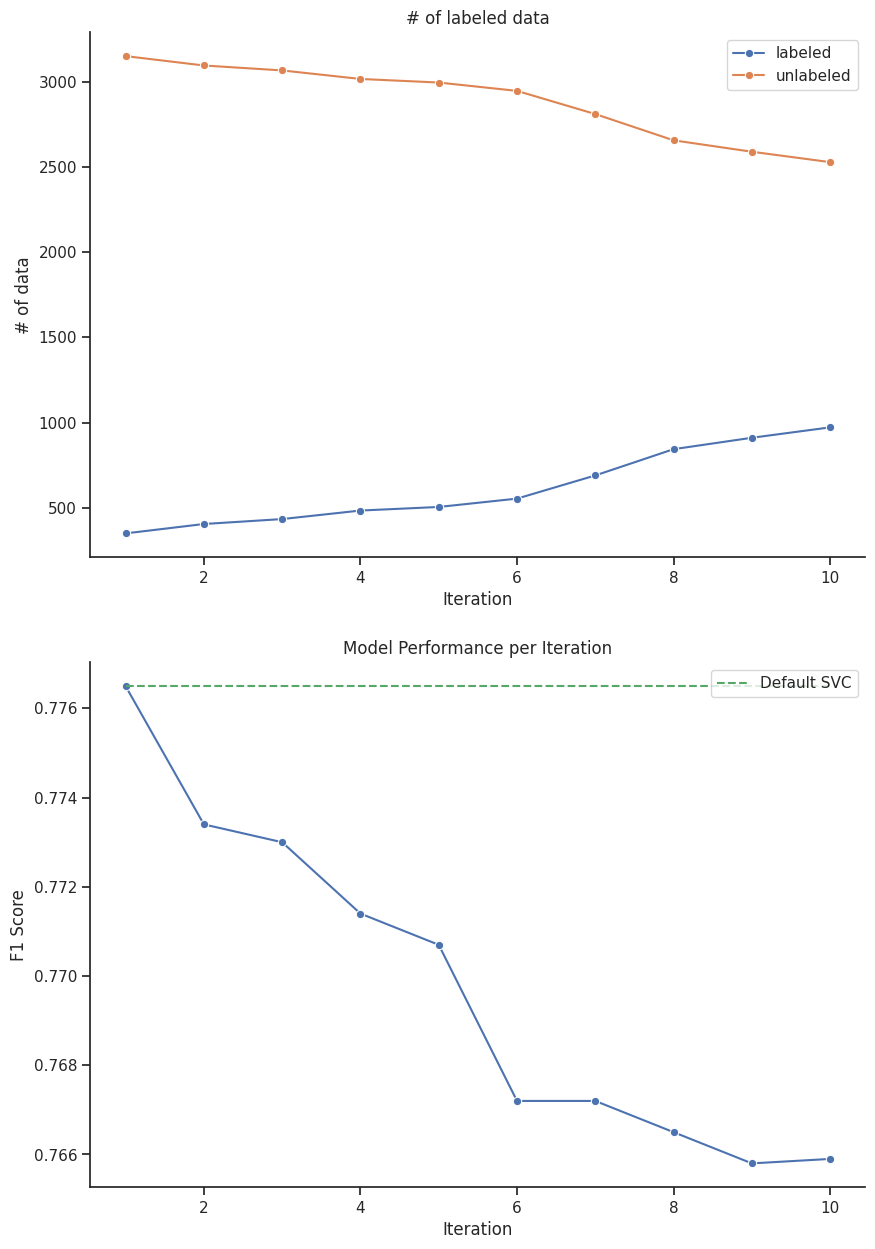

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.lineplot(x=range(1, 11), y=len_labeled, ax=axs[0], legend=True, label='labeled', marker='o')
sns.lineplot(x=range(1, 11), y=len_unlabeled, ax=axs[0], legend=True, label='unlabeled', marker='o')
axs[0].set_title("# of labeled data")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("# of data")

sns.lineplot(x=range(1, 11), y=pd.DataFrame(result_dict_for_threshold).T['F1 Score'], ax=axs[1], marker='o')
axs[1].set_title("Model Performance per Iteration")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("F1 Score")
# axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[0]['F1 Score'], xmin=1, xmax=10, colors='r', linestyles='dashed', label='Full Trained SVC')
axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[1]['F1 Score'], xmin=1, xmax=10, colors='g', linestyles='dashed', label='Default SVC')
axs[1].legend()
plt.show()

In [ ]:
comparison_lab_dict['lab_350_best_st_threshold'] = result_dict_for_threshold['Self Train(iter: 2)']

In [ ]:
pd.DataFrame(comparison_lab_dict).T

,F1 Score,Recall,Precision,Accuracy,AUROC,# of labeled data,# of unlabeled data
full,0.7965,0.8692,0.7350,0.7827,0.7845,NaN,NaN
lab_35,0.6054,0.5518,0.6705,0.6480,0.6460,NaN,NaN
lab_35_best_st,0.6383,0.6744,0.6059,0.6260,0.6270,3009.0,491.0
lab_350_best_st,0.7704,0.8665,0.6936,0.7473,0.7498,2542.0,958.0
lab_350,0.7765,0.9087,0.6778,0.7440,0.7474,NaN,NaN
lab_350_best_st_threshold,0.7734,0.9114,0.6717,0.7387,0.7423,434.0,3066.0


threshold를 변경하면, 모델의 예측 확률(confidence)가 높은 데이터에 대해서만 pseudo labeling이 진행됩니다.\
이를 통해 self train 과정 상의 성능 저하를 막고, 더 나은 성능을 기대할 수 있습니다.\
실제로 위 두 실험에서도 threshold를 변경하여 성능 저하가 느려지는 것을 확인할 수 있습니다.

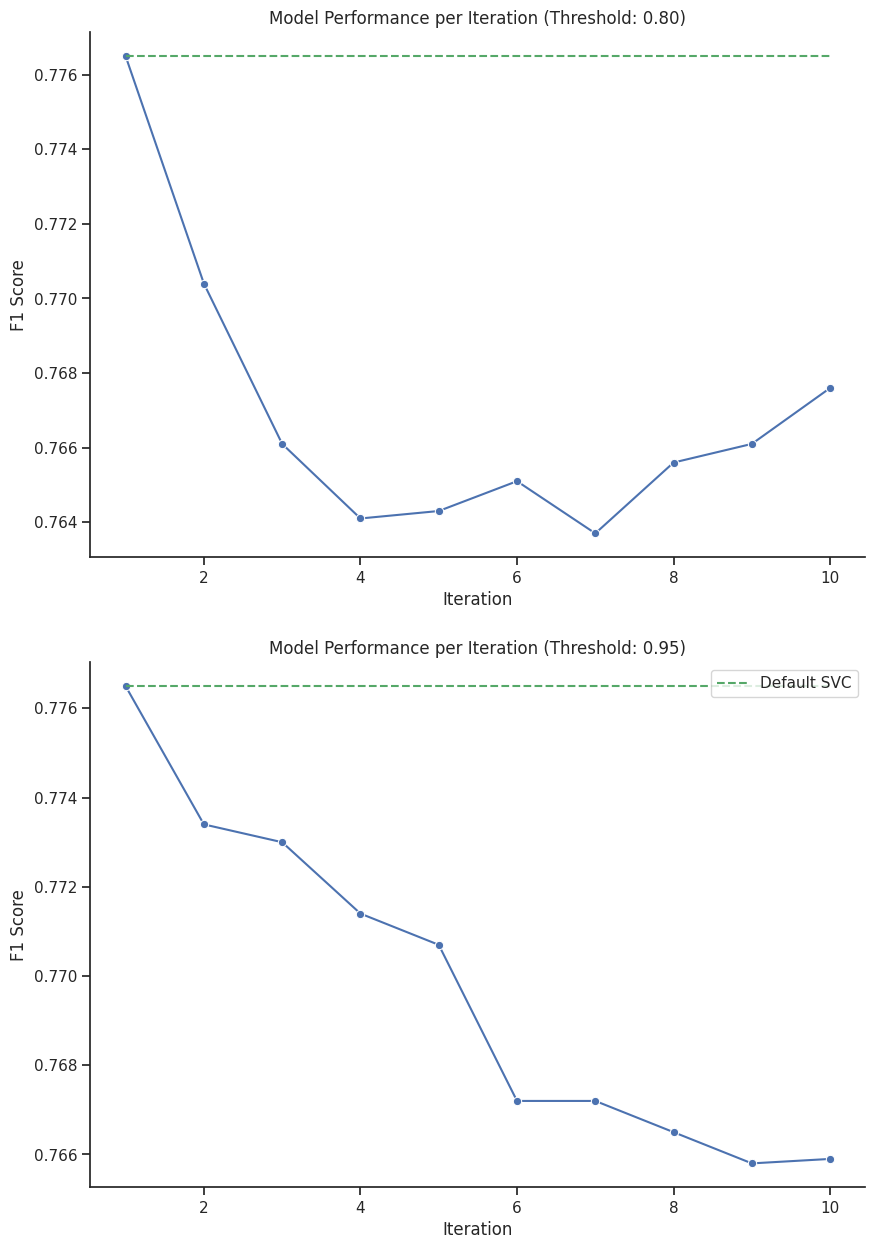

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.lineplot(x=range(1, 11), y=pd.DataFrame(result_dict).T.iloc[1:]['F1 Score'], ax=axs[0], marker='o')
axs[0].set_title("Model Performance per Iteration (Threshold: 0.80)")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("F1 Score")
axs[0].hlines(y=pd.DataFrame(result_dict).T.iloc[1]['F1 Score'], xmin=1, xmax=10, colors='g', linestyles='dashed', label='Default SVC')

sns.lineplot(x=range(1, 11), y=pd.DataFrame(result_dict_for_threshold).T['F1 Score'], ax=axs[1], marker='o')
axs[1].set_title("Model Performance per Iteration (Threshold: 0.95)")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("F1 Score")
axs[1].hlines(y=pd.DataFrame(result_dict).T.iloc[1]['F1 Score'], xmin=1, xmax=10, colors='g', linestyles='dashed', label='Default SVC')
axs[1].legend()
plt.show()

## 7-3. Iteration 당 pseudo labeling 정확도 변화

In [ ]:
result_dict_for_threshold = defaultdict(dict)
new_labeled_x = X_lab_train.copy()
new_labeled_y = y_lab_train.copy()
new_unlabeled_x = X_unlab_train.copy()
new_unlabeled_y = y_unlab_train.copy()

len_labeled = []
len_unlabeled = []

for iter in range(10):
    len_labeled.append(len(new_labeled_x))
    len_unlabeled.append(len(new_unlabeled_x))
    model = copy.deepcopy(SVC(probability=True, random_state=42))
    model, new_labeled_x, new_labeled_y, original_y, new_unlabeled_x, new_unlabeled_y = self_train_iter(model, new_labeled_x, new_labeled_y, new_unlabeled_x, new_unlabeled_y, threshold=0.95)

    # pseudo labeling 결과 분석
    label_dist = np.array([0,0])
    lab_key, label_cnt = np.unique(original_y, return_counts=True)
    for key, dist in zip(lab_key, label_cnt):
        label_dist[key] = dist
    pred = new_labeled_y[-len(original_y):]

    label_0_pred = pred[original_y == 0]
    label_1_pred = pred[original_y == 1]

    label_0_acc = np.mean(label_0_pred == 0)
    label_1_acc = np.mean(label_1_pred == 1)

    print(f"""
==========================================================================================
Self Train(iter: {iter+1})
==============================
pseudo labeling이 수행된 unlabeled data의 label 분포:
    - 0번 레이블: {label_dist[0]}
    - 1번 레이블: {label_dist[1]}
------------------------------
pseudo labeling이 수행된 unlabeled data의 label별 정확도:
    - 0번 레이블: {label_0_acc:.4f}
    - 1번 레이블: {label_1_acc:.4f}
          """)

    # Calculate and print various evaluation metrics
    # print(f'Self Train(iter: {iter+1})')
    # svm_metrics = calc_metrics(y_true=y_label, y_pred=y_pred)
    # svm_metrics = {'# of labeled data': len(new_labeled_x), '# of unlabeled data': len(new_unlabeled_x), **svm_metrics}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Self Train(iter: 1)
pseudo labeling이 수행된 unlabeled data의 label 분포: 
    - 0번 레이블: 55
    - 1번 레이블: 0
------------------------------
pseudo labeling이 수행된 unlabeled data의 label별 정확도: 
    - 0번 레이블: 1.0000
    - 1번 레이블: nan
          

Self Train(iter: 2)
pseudo labeling이 수행된 unlabeled data의 label 분포: 
    - 0번 레이블: 29
    - 1번 레이블: 0
------------------------------
pseudo labeling이 수행된 unlabeled data의 label별 정확도: 
    - 0번 레이블: 1.0000
    - 1번 레이블: nan
          

Self Train(iter: 3)
pseudo labeling이 수행된 unlabeled data의 label 분포: 
    - 0번 레이블: 49
    - 1번 레이블: 1
------------------------------
pseudo labeling이 수행된 unlabeled data의 label별 정확도: 
    - 0번 레이블: 1.0000
    - 1번 레이블: 0.0000
          

Self Train(iter: 4)
pseudo labeling이 수행된 unlabeled data의 label 분포: 
    - 0번 레이블: 20
    - 1번 레이블: 1
------------------------------
pseudo labeling이 수행된 unlabeled data의 label별 정확도: 
    - 0번 레이블: 1.0000
    - 1번 레이블: 0.0000
          

Self Train(iter: 5)
pseudo labeling이 수행된 unlabeled data의 labe